# Méthodes d'interpolation

Dans ce TP, nous allons tester différentes méthodes d'interpolation en dimension 1 d'espace. Tout peut se généraliser en dimension supérieure mais demande un peu de technique.

Nous commençons par la méthode classique d'interpolation par des polynômes interpolateurs de Lagrange et nous testons ensuite la méthode de krigeage.

In [203]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [204]:
colors = mpl.cm.rainbow(np.linspace(0, 1, 1000))

def color_gen():
    k = np.random.randint(colors.shape[0], size=1)[0]
    return colors[k,:]

Text(0.5, 1.0, 'Nuage de points')

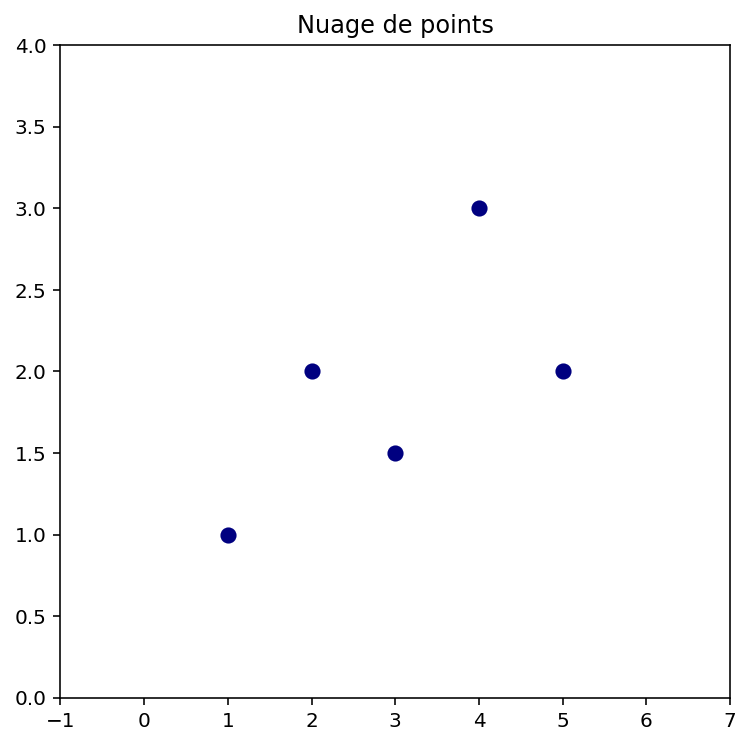

In [220]:
a, b, c, d = -1, 7, 0, 4
n = 301 #6 * X + 1 avec X entier
x = np.linspace(a, b, n)
X = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
Y = np.array([1.0, 2.0, 1.5, 3.0, 2.0])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X, Y, s=50, color='navy')
ax.set_xlim(a, b)
ax.set_ylim(c, d)
ax.set_title('Nuage de points')

## Les polynômes interpolateurs de Lagrange

La technique d'interpolation par des polynômes interpolateurs de Lagrange repose sur le théorème suivant.

> **Théorème (Polynôme interpolateur de Lagrange)**<br>
> Soient $(X_1,\ldots,X_N)$ et $(Y_1,\ldots Y_N)$ tels que $X_i\neq X_j$ si $i\neq j$.<br>
  Il existe un unique polynôme $P\in\mathbb{R}_{N-1}[X]$ tel que $P(X_i)=Y_i$ pour tout $1\leq i\leq N$.
  
De nombreuses méthodes existent pour déterminer le polynôme interpolateur de Lagrange et surtout l'évaluer en un grand nombre de points (pour le tracer par exemple). Nous choisissons ici la plus simple et la moins efficace (car elle est utilisée dans la méthode de krigeage plus loin) mais elle suffit ici puisque nous montrons assez vite qu'elle ne permet pas de résoudre notre problème.

Ainsi, nous définissons $V$ la matrice de Vandermonde associé au vecteur $(X_1,\ldots,X_N)$
$$
V = \begin{pmatrix}
1&X_1&\ldots&X_1^{N-1}\\
\vdots&\vdots&\vdots\\
1&X_N&\ldots&X_N^{N-1}
\end{pmatrix}.
$$
Le polynôme interpolateur de Lagrange associé aux points $X$ et $Y$ s'écrit alors
$$ P(X) = \sum_{i=0}^{N-1} \alpha_i X^i $$
où le vecteur $\alpha=(\alpha_0,\ldots,\alpha_{N-1})$ est solution de $V\alpha=Y$.

**Question**

> * Proposez une fonction `interp_Lagrange` qui prend en arguments 3 `ndarray` contenant les points d'interpolation $(X_1,\ldots,X_N)$, $(Y_1,\ldots,Y_N)$ et les points $(x_1,\ldots,x_n)$ où le polynôme $P$ est évalué et qui retourne un `ndarray` $y$ tel que $y_i = P(x_i)$ pour $1\leq i\leq n$.
> * Testez cette fonction en prenant pour points d'interpolation les points $X$ et $Y$ donnés en début de notebook.
> * Expliquez pourquoi l'interpolation par un polynôme ne permet pas d'avoir une bonne représentation des données.

In [218]:
def interp_Lagrange(X,Y,x):
    n = len(X)
    V = np.ones((n,n))
    for i in np.arange(n):
        V[:,i] = X**i
    
    alpha = np.linalg.solve(V,Y)
    
    #evaluation du plonome en x P(x) = sum
    y = np.zeros(x.shape)
    print(x.shape)
    print(alpha)
    for a in alpha[::-1]:
        y = y*x + a
    
    return y

(1000,)
[-13.          26.33333333 -15.91666667   3.91666667  -0.33333333]
(1000,)
[-13.          26.33333333 -15.91666667   3.91666667  -0.33333333]


Text(0.5, 1.0, 'Nuage de points')

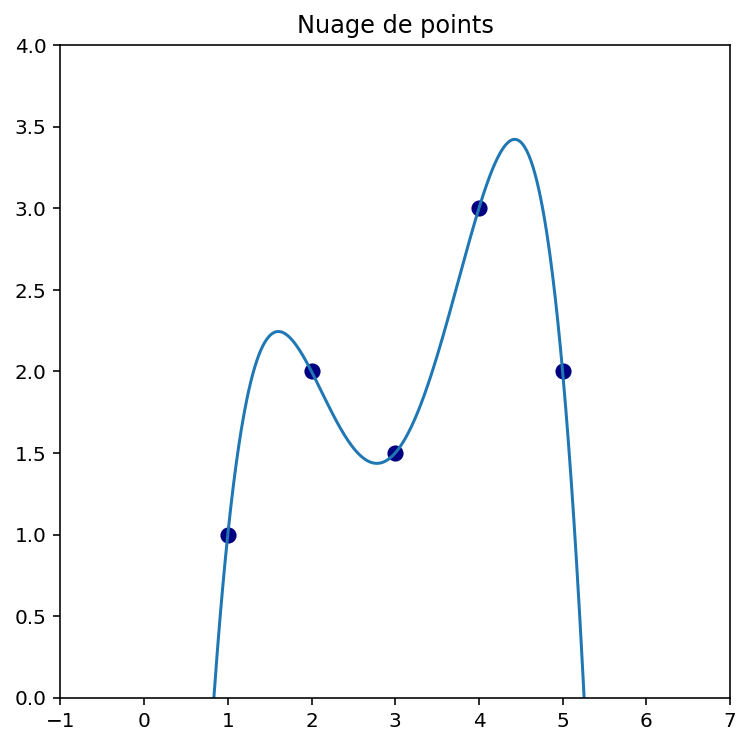

In [219]:
y = interp_Lagrange(X,Y, x)

a, b, c, d = -1, 7, 0, 4
n = 1000
x = np.linspace(a, b, n)
X = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
Y = np.array([1.0, 2.0, 1.5, 3.0, 2.0])

y = interp_Lagrange(X,Y,x)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X, Y, s=50, color='navy')
ax.plot(x, y)
ax.set_xlim(a, b)
ax.set_ylim(c, d)
ax.set_title('Nuage de points')

# Méthode de krigeage



**Question**

> * Définissez les différentes fonctions $g$ (puissance, sphérique, exponentielle, gaussienne) proposées dans le cours.
> * Ajoutez l'effet pépite en pondérant comme une combinaison linéaire convexe les fonctions.
> * Affichez les sur un même graphique.

Question

* Définissez les différentes fonctions $g$ (puissance, sphérique, exponentielle, gaussienne) proposées dans le cours.
* Ajoutez l'effet pépite en pondérant comme une combinaison linéaire convexe les fonctions.
* Affichez les sur un même graphique.

*Comentaire
On a une fonction g_puissance
$$ g(h) = (1-(h/a))^n \boldsymbol{1}_{[0,a]}(h) $$

On a aussi une fonction g_pepite
$$ g^p(h) = 1 \text{ si } h =0  \text{ et } 0 \text{ si non } $$
Pour l'effet pépite, on fait une combinaison linéaire entre ces deux fonctions :
$$
g(h) = pepite * g^p(h) + (1-pepite) * g^m(h)
$$

In [216]:
def g_puissance(h,m,a, pepite = 0):
    if a == np.inf:
        out = 1-h
    else:
        out = (1- (h/a)**m) * (h<a)
    if pepite !=0:
        out[h>0] *= 1-pepite
    return out

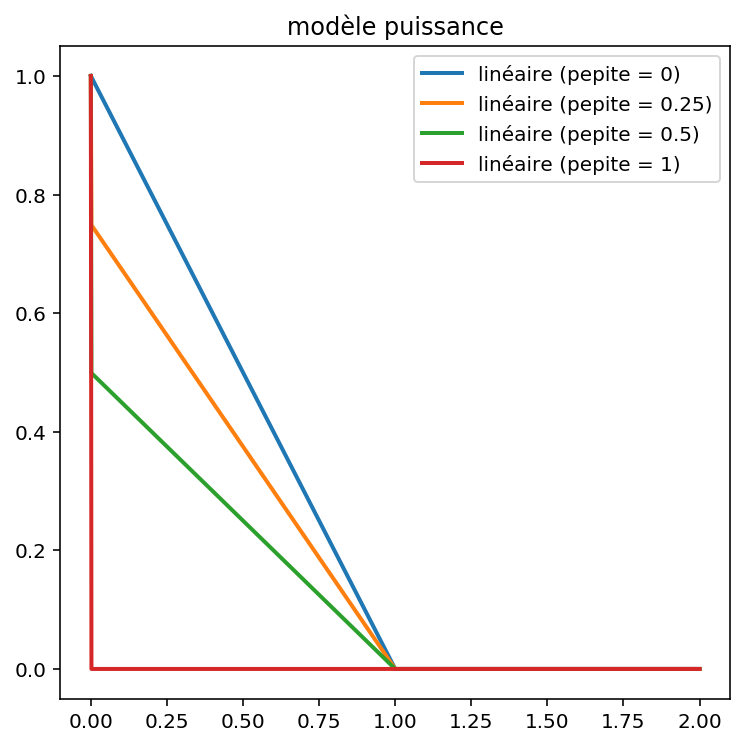

In [217]:
palier = 1
h = np.linspace(0,2*palier, 1000)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

for pepite in [0,0.25,0.5,1]:
    ax.plot(
    h, g_puissance(h,1,palier,pepite=pepite),
    label =f'linéaire (pepite = {pepite})', linewidth=2 
    )

ax.legend()
ax.set_title("modèle puissance")
plt.show()

**Question**

> * Proposez une fonction `krigeage` sur le même modèle que la fonction `interp_Lagrange` en lui passant également en paramètre le modèle choisi.
> * Affichez les différentes interpolations obtenues pour les différents modèles avec ou sans pépite.

In [199]:
def krigeage(X,Y,x, modele):
    
    M = modele['M']
    g = modele['g']
    
    N = X.size
    
    if Y.size != N:
        print("erreur")
        return
    
    V = np.zeros((N+M,N+M))

    for k in range(M):
        V[:N, N+k] = X**k
        V[N+k, :N] = X**k
    V[:N,:N] = g(abs(X[:, np.newaxis] - X[ np.newaxis, :]))

    sndmb = np.zeros((N+M,))
    sndmb[:N] = Y
    
    sol = np.linalg.solve(V,sndmb)
    alpha, beta = sol[:N], sol[N:]
    
    #evaluation du plonome en x P(x) = sum
    y = np.zeros(x.shape)
    print(x.shape)
    for a in beta[::-1]:
        y = y*x + a
    for i, alphai in enumerate(alpha):
        y += alphai*g(abs(x-X[i]))
    
    return y 
    
    

(1000,)


Text(0.5, 1.0, 'Krigeage')

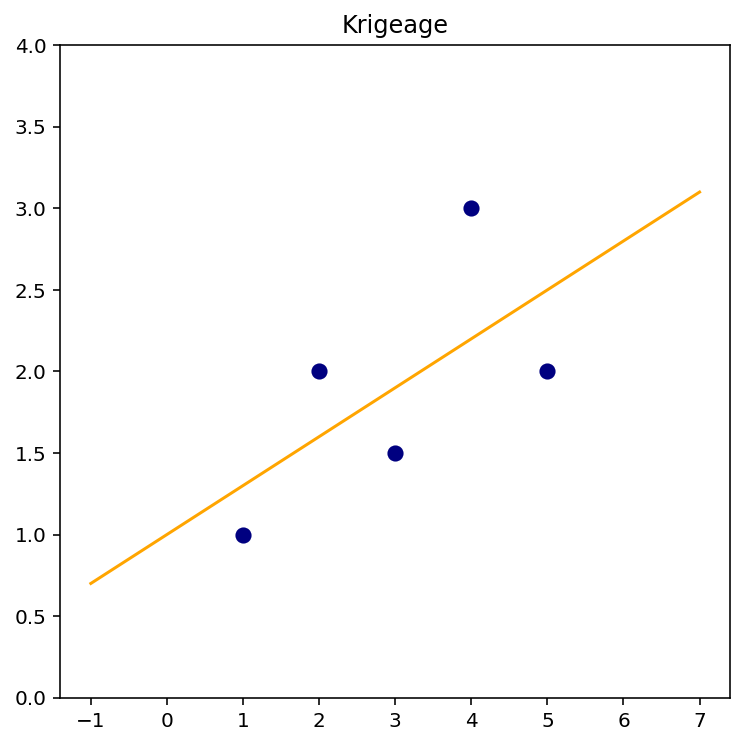

In [200]:
modele = {
    'M': 2,
    'g': lambda h: g_puissance(h,3,a=0.25,pepite=1)
}

y = krigeage(X,Y,x,modele)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim(0,4)
ax.scatter(X, Y, s=50, color='navy')
ax.plot(x, y, color='orange')
ax.set_title('Krigeage')